In [1]:
import abc
import numpy as np
import dataclasses
import enact

def normalize_angle(theta: np.ndarray) -> np.ndarray:
  return (theta + np.pi) % (2 * np.pi) - np.pi

@enact.register
@dataclasses.dataclass
class Action(enact.Resource):
  torque: float
  thrust: float

@enact.register
@dataclasses.dataclass
class State(enact.Resource):
  """Represents a game state.

  The state is represented internally as a numpy array of length 10.
  State components can be accessed with setters and getters:
  * Agent position
  * Agent orientation [-pi, pi]
  * Agent velocity
  * Agent angular speed
  * Goal position
  * Has been at goal

  A state object may represent an arbitrary batch of states.
  """

  # Indices and slices into the underlying arrays.
  POSITION_SLICE = slice(0, 2)
  ROTATION_INDEX = 2
  VELOCITY_SLICE = slice(3, 5)
  ANGULAR_VELOCITY_INDEX = 5
  GOAL1_POSITION_SLICE = slice(6, 8)
  HAS_BEEN_AT_GOAL1_INDEX = 8
  GOAL2_POSITION_SLICE = slice(9, 11)
  HAS_BEEN_AT_GOAL2_INDEX = 11
  # Total dimensionality of the state space array.
  ARRAY_SIZE = 12

  # Game configuration.
  BOARD_SIZE = 25
  REACHED_EPSILON = 1
  TORQUE_FORCE = 0.5
  THRUST_FORCE = 0.5
  MAX_SPEED = 2
  FRICTION_COEFFICIENT = 0.99

  array: np.ndarray = np.zeros((1, ARRAY_SIZE))

  def randomize(self):
    batch_shape = self.array.shape[:-1]
    self.position = np.random.uniform(0, State.BOARD_SIZE, batch_shape + (2,))
    self.rotation = np.random.uniform(-np.pi, np.pi, batch_shape)
    self.goal1_position = np.random.uniform(
      0, State.BOARD_SIZE, batch_shape + (2,))
    self.goal2_position = np.random.uniform(
      0, State.BOARD_SIZE, batch_shape + (2,))
    self.success = np.zeros_like(self.rotation)

  @property
  def position(self) -> np.ndarray:
    """Return the position of the agent."""
    return self.array[..., State.POSITION_SLICE]

  @position.setter
  def position(self, value: np.ndarray):
    """Set the position of the agent."""
    self.array[..., State.POSITION_SLICE] = value

  @property
  def rotation(self) -> np.ndarray:
    """Return the rotation of the agent. Positive is counter-clockwise."""
    return self.array[..., State.ROTATION_INDEX]

  @rotation.setter
  def rotation(self, value: np.ndarray):
    """Set the rotation of the agent (normalized to [-pi, pi])."""
    self.array[..., State.ROTATION_INDEX] = normalize_angle(value)

  @property
  def velocity(self) -> np.ndarray:
    """Two dimensional velocity vector of the agent."""
    return self.array[..., State.VELOCITY_SLICE]

  @velocity.setter
  def velocity(self, value: np.ndarray):
    """Set the velocity."""
    self.array[..., State.VELOCITY_SLICE] = value

  @property
  def angular_velocity(self) -> np.ndarray:
    """The angular velocity of the agent."""
    return self.array[..., State.ANGULAR_VELOCITY_INDEX]

  @angular_velocity.setter
  def angular_velocity(self, value: np.ndarray):
    """Set the angular velocity of the agent."""
    self.array[..., State.ANGULAR_VELOCITY_INDEX] = value

  @property
  def goal1_position(self) -> np.ndarray:
    """The position of the goal."""
    return self.array[..., State.GOAL1_POSITION_SLICE]

  @goal1_position.setter
  def goal1_position(self, value: np.ndarray):
    """Set the position of the goal."""
    self.array[..., State.GOAL1_POSITION_SLICE] = value

  @property
  def has_been_at_goal1(self) -> np.ndarray:
    """Whether the agent has been at the goal."""
    return self.array[..., State.HAS_BEEN_AT_GOAL1_INDEX]

  @has_been_at_goal1.setter
  def has_been_at_goal1(self, value: np.ndarray):
    """Set whether the agent has been at the goal."""
    self.array[..., State.HAS_BEEN_AT_GOAL1_INDEX] = value

  @property
  def goal2_position(self) -> np.ndarray:
    """The position of the goal."""
    return self.array[..., State.GOAL2_POSITION_SLICE]

  @goal2_position.setter
  def goal2_position(self, value: np.ndarray):
    """Set the position of the goal."""
    self.array[..., State.GOAL2_POSITION_SLICE] = value

  @property
  def has_been_at_goal2(self) -> np.ndarray:
    """Whether the agent has been at the goal."""
    return self.array[..., State.HAS_BEEN_AT_GOAL2_INDEX]

  @has_been_at_goal2.setter
  def has_been_at_goal2(self, value: np.ndarray):
    """Set whether the agent has been at the goal."""
    self.array[..., State.HAS_BEEN_AT_GOAL2_INDEX] = value

  def forward(self, offset: float=0) -> np.ndarray:
    """The unit vector pointing forward relative to the agent."""
    return np.stack([np.cos(self.rotation + offset),
                     np.sin(self.rotation + offset)], axis=-1)

  def right(self, offset: float=0) -> np.ndarray:
    """The unit vector pointing right relative to the agent."""
    return self.forward(offset - np.pi / 2)

  def at_goal1(self) -> np.ndarray:
    """Whether the agent is currently at the goal."""
    return np.linalg.norm(
      self.position - self.goal1_position, axis=-1) < State.REACHED_EPSILON

  def at_goal2(self) -> np.ndarray:
    """Whether the agent is currently at the goal."""
    return np.linalg.norm(
      self.position - self.goal2_position, axis=-1) < State.REACHED_EPSILON

In [2]:
import asyncio
import contextlib
import dataclasses
from typing import Optional


class AsyncPolicy(abc.ABC):
  @abc.abstractmethod
  async def compute_actions(self, observations: State) -> Action:
    """Compute actions from observations."""
  
  @abc.abstractmethod
  async def stop(self):
    """Stop the policy."""
  

class Game:
  def __init__(self, policy: AsyncPolicy):
    self.policy = policy
    self.state = State()
    self.state.randomize()
    self.steps = 300

  async def dynamics(self, actions: Action) -> State:
    dt = 0.1
    next_state = State(np.copy(self.state.array))
    # Update velocity by applying acceleration forces.
    thrust = np.array([np.clip(actions.thrust, 0, 1)])
    torque = np.array([np.clip(actions.torque, -1, 1)])
    next_state.velocity += (
        dt * self.state.THRUST_FORCE *
        self.state.forward() * np.expand_dims(thrust, axis=-1))
    next_state.angular_velocity += dt * self.state.TORQUE_FORCE * torque

    # Clamp max speed and apply friction.
    speed = np.clip(
        np.expand_dims(np.linalg.norm(next_state.velocity, axis=-1), -1),
        1e-10, np.infty)

    at_maxed_out_speed = (next_state.velocity / speed) * self.state.MAX_SPEED
    next_state.velocity = np.where(
        speed > self.state.MAX_SPEED, at_maxed_out_speed, next_state.velocity)

    next_state.velocity *= self.state.FRICTION_COEFFICIENT
    next_state.angular_velocity *= self.state.FRICTION_COEFFICIENT

    # Update position by applying velocity.
    next_state.position += dt * next_state.velocity
    next_state.rotation += dt * next_state.angular_velocity

    next_state.has_been_at_goal1 += next_state.at_goal1()
    next_state.has_been_at_goal1 = np.clip(next_state.has_been_at_goal1, 0, 1)

    next_state.has_been_at_goal2 += next_state.at_goal2()
    next_state.has_been_at_goal2 = np.clip(next_state.has_been_at_goal2, 0, 1)

    return next_state
  
  async def update(self):
    actions = await self.policy.compute_actions(self.state)
    self.state = await self.dynamics(actions)
  
  async def game_loop(self):
    for i in range(self.steps):
      await self.update()
    await self.policy.stop()
  
@enact.typed_invokable(Action, enact.NPArray)
class Step(enact.Invokable):
  def call(self, action: Action) -> enact.NPArray:
    api = PolicyAPI.current()
    return enact.NPArray(api.state.position)


@enact.contexts.register
@enact.typed_invokable(enact.NoneResource, enact.NoneResource)
@dataclasses.dataclass
class PolicyAPI(enact.AsyncInvokable, enact.contexts.Context):
  """Runs a policy and exposes an API to the game."""
  policy: enact.AsyncInvokable
  record_step: Step = dataclasses.field(default_factory=Step)

  def __post_init__(self):
    enact.contexts.Context.__init__(self)
    self.started = asyncio.Event()
    self.has_observation = asyncio.Event()
    self.has_action = asyncio.Event()
    self.is_done = asyncio.Event()
    self.game: Optional[Game] = None
    self.action: Optional[Action] = None
  
  @contextlib.contextmanager
  def connect_to(self, game: Game):
    self.game = game
    with self:
      try:
        yield
      finally:
        self.game = None

  @property
  def state(self) -> State:
    return self.game.state

  async def stop(self):
    """Stop the policy."""
    self.is_done.set()
  
  async def compute_actions(self, observations: State) -> Action:
    await asyncio.wait_for(self.started.wait(), timeout=1.0)
    self.has_observation.set()
    await self.has_action.wait()
    self.has_action.clear()
    assert self.action is not None
    return self.action

  async def init(self):
    self.started.set()
    await asyncio.wait_for(self.has_observation.wait(), timeout=1.0)

  async def step(self, action: Action):
    self.record_step(action)
    self.action = action
    self.has_action.set()
    await self.has_observation.wait()
    self.has_observation.clear()
    
  async def call(self):
    await self.init()
    policy_task = asyncio.create_task(self.policy())
    done, _ = await asyncio.wait(
      [policy_task, self.is_done.wait()],
      return_when=asyncio.FIRST_COMPLETED)
    if policy_task in done and not len(done) == 2:
      raise ValueError('Policy completed before game.')
    policy_task.cancel()
    try:
      await policy_task
    except asyncio.CancelledError:
      pass


@enact.typed_invokable(enact.NoneResource, PolicyAPI)
class CoroutinePolicy(enact.AsyncInvokable):
  def api(self) -> PolicyAPI:
    return PolicyAPI.current()


In [65]:
@enact.register
@dataclasses.dataclass
class AimAt(CoroutinePolicy):

  target: list

  def get_torque(self) -> float:
    api = self.api()
    diff_vector = np.array(self.target)[0] - api.state.position[0]
    goal_direction = np.arctan2(diff_vector[1], diff_vector[0])
    delta_angle = np.arctan2(np.sin(goal_direction - api.state.rotation[0]),
                              np.cos(goal_direction - api.state.rotation[0]))
    normalized_delta_angle = delta_angle / np.pi
    return normalized_delta_angle

  def get_thrust(self) -> float:
    return 1.

  async def step(self, action: Action):
    api = self.api()
    await api.step(action)

  async def call(self):
    while True:
      torque = self.get_torque()
      thrust = self.get_thrust()
      
      action = Action(torque, thrust)
      await self.step(action)


@enact.typed_invokable(enact.NoneResource, enact.NoneResource)
class ChangeAim(CoroutinePolicy):

  async def call(self):
    print('Calling ChangeAim.')
    counter = 0
    while True:
      print(f'Counter: {counter}')
      counter += 1
      target = np.random.uniform(0, 25, ((1, 2)))
      aim_at = AimAt(target.tolist())
      await aim_at()

In [66]:
with enact.InMemoryStore() as store:
  enact.commit(AimAt(np.zeros((1, 2)).tolist()))

In [ ]:
api = PolicyAPI(ChangeAim())
game = Game(api)
with enact.InMemoryStore() as store:
  with api.connect_to(game):
    invocation, _ = await asyncio.gather(api.invoke(), game.game_loop())


In [68]:
import numpy as np
from matplotlib import pyplot as plt

def get_observations(i: enact.Invocation, aim_target: Optional[list]=None):
  if aim_target is None:
    aim_target = [[0., 0.]]
  if isinstance(i.request().invokable(), Step):
    yield [*i.response().output().value.tolist(), aim_target]
  elif isinstance(i.request().invokable(), AimAt):
    aim_target = i.request().invokable().target
  for c in i.get_children():
    yield from get_observations(c, aim_target)

with store:
  obs_list = list(get_observations(invocation))
  position = np.array([o[0] for o in obs_list])
  goal = np.array([o[1][0] for o in obs_list])
  print(f'Position Shape: {position.shape}')
  print(f'Goal Shape: {goal.shape}')

Position Shape: (301, 2)
Goal Shape: (301, 2)


(0.0, 25.0)

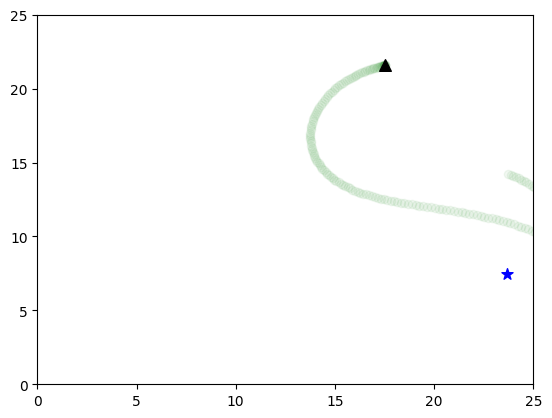

In [69]:
plt.scatter(position[:, 0], position[:, 1], alpha=0.05, c='g')
plt.scatter(position[0, 0], position[0, 1], c='k', marker='^', s=70, alpha=1)
plt.scatter(goal[0, 0], goal[0, 1], marker='*', s=70, c='b')
plt.xlim((0, 25))
plt.ylim((0, 25))

In [78]:
def get_actions(i: enact.Invocation, action: Optional[Action]=None):
  if isinstance(i.request().invokable(), Step):
    yield [i.request().input()]
  for c in i.get_children():
    yield from get_actions(c, action)

with store:
  actions_list = list(get_actions(invocation))
  actions_list = [a[0] for a in actions_list]

In [79]:
actions_list

[Action(torque=0.5405720373669003, thrust=1.0),
 Action(torque=0.5405720373669003, thrust=1.0),
 Action(torque=0.5398218254224173, thrust=1.0),
 Action(torque=0.5383300956475472, thrust=1.0),
 Action(torque=0.5361066324628212, thrust=1.0),
 Action(torque=0.5331622820738318, thrust=1.0),
 Action(torque=0.5295089214270323, thrust=1.0),
 Action(torque=0.5251594247868718, thrust=1.0),
 Action(torque=0.520127628090045, thrust=1.0),
 Action(torque=0.5144282912433863, thrust=1.0),
 Action(torque=0.5080770585417651, thrust=1.0),
 Action(torque=0.5010904173911502, thrust=1.0),
 Action(torque=0.49348565552970497, thrust=1.0),
 Action(torque=0.48528081694620195, thrust=1.0),
 Action(torque=0.4764946567000886, thrust=1.0),
 Action(torque=0.46714659485103255, thrust=1.0),
 Action(torque=0.4572566697076041, thrust=1.0),
 Action(torque=0.4468454906047842, thrust=1.0),
 Action(torque=0.4359341904181223, thrust=1.0),
 Action(torque=0.42454437801854505, thrust=1.0),
 Action(torque=0.4126980908659999, th

In [80]:
torque_vals = [a.torque for a in actions_list]
thrust_vals = [a.thrust for a in actions_list]

In [81]:
import seaborn as sns

Text(0.5, 1.0, 'Generated Policy Actions')

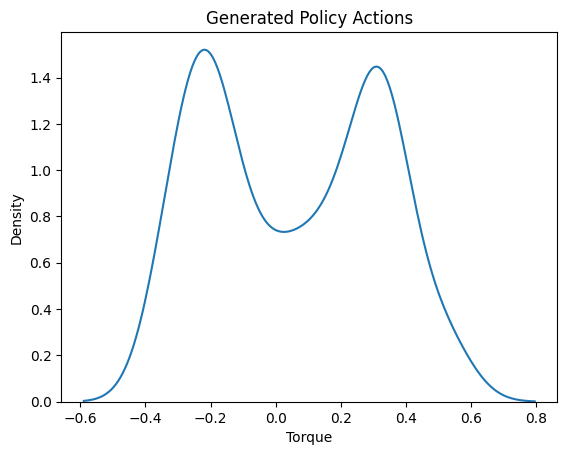

In [85]:
sns.kdeplot(np.array(torque_vals))
plt.xlabel('Torque')
plt.title('Generated Policy Actions')

In [41]:
i = invocation.get_child(0).get_child(0).get_child(0)
i

Invocation(request=<Ref: 9304b4c0f697d766bdf51704b384ca6652b7b6f8389ee3e028f4ce4d9d1ddf1c>, response=<Ref: 869e0c7c6fffbe8987825c5399e2424caad4512f80cbc805a55440697e9ebcd9>)

In [45]:
i.request().input()

Action(torque=-0.1990271318310985, thrust=1.0)

In [44]:
i.response().invokable().

Step()